<a href="https://colab.research.google.com/github/paulcodrea/dissertation/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
### Credit to Aaron-Paul

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
# import pyspark as spark
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
# sc = spark.SparkContext()
# sql = spark.SQLContext(sc)
# from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# from elephas.utils.rdd_utils import to_simple_rdd

In [54]:
df = pd.read_csv('/content/merged_df.csv')#('/content/drive/My Drive/merged_df.csv')
df.head()

,Date,sentiment,close,coin_type
0,2022-01-13 17:00,0.206676,0.1629,DOGE
1,2022-01-13 18:00,0.175150,0.1627,DOGE
2,2022-01-13 19:00,0.187216,0.1630,DOGE
3,2022-01-13 20:00,0.190882,0.1660,DOGE
4,2022-01-13 21:00,0.197966,0.1707,DOGE


In [55]:
print(len(df))

120


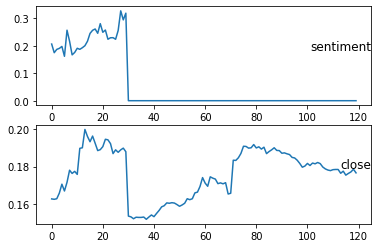

In [56]:
values = df.values
# specify columns to plot
groups = [1, 2]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [57]:
df.set_index('Date',inplace=True)
df.drop(columns=['coin_type'], inplace=True)
df.rename(columns={'close':'Price'}, inplace=True)

In [58]:
df = df[['Price', 'sentiment']]

In [59]:
df.head()

,Price,sentiment
Date,,
2022-01-13 17:00,0.1629,0.206676
2022-01-13 18:00,0.1627,0.175150
2022-01-13 19:00,0.1630,0.187216
2022-01-13 20:00,0.1660,0.190882
2022-01-13 21:00,0.1707,0.197966


In [60]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [61]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [62]:
n_hours = 3  #no of time lags
n_features = 1 #no of features
n_obs = n_hours*n_features

In [63]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
3,0.226891,0.630586,0.222689,0.534399,0.228992,0.571213,0.292017,0.582397
4,0.222689,0.534399,0.228992,0.571213,0.292017,0.582397,0.390756,0.604012
5,0.228992,0.571213,0.292017,0.582397,0.390756,0.604012,0.315126,0.494202
6,0.292017,0.582397,0.390756,0.604012,0.315126,0.494202,0.411765,0.784741
7,0.390756,0.604012,0.315126,0.494202,0.411765,0.784741,0.546218,0.662172


In [64]:
reframed = reframed.drop(reframed.columns[-1], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
3,0.226891,0.630586,0.222689,0.534399,0.228992,0.571213,0.292017
4,0.222689,0.534399,0.228992,0.571213,0.292017,0.582397,0.390756
5,0.228992,0.571213,0.292017,0.582397,0.390756,0.604012,0.315126
6,0.292017,0.582397,0.390756,0.604012,0.315126,0.494202,0.411765
7,0.390756,0.604012,0.315126,0.494202,0.411765,0.784741,0.546218


In [65]:
# print(len(reframed))

In [71]:
values = reframed.values
n_train_hours = 110
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(110, 7)

In [72]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [73]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(110, 3, 1) (110,) (7, 3, 1) (7,)


In [82]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=4, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Epoch 1/20
28/28 - 3s - loss: 0.4767 - val_loss: 0.4408 - 3s/epoch - 100ms/step
Epoch 2/20
28/28 - 0s - loss: 0.4070 - val_loss: 0.3548 - 93ms/epoch - 3ms/step
Epoch 3/20
28/28 - 0s - loss: 0.3308 - val_loss: 0.2523 - 95ms/epoch - 3ms/step
Epoch 4/20
28/28 - 0s - loss: 0.2582 - val_loss: 0.1424 - 94ms/epoch - 3ms/step
Epoch 5/20
28/28 - 0s - loss: 0.1975 - val_loss: 0.0409 - 92ms/epoch - 3ms/step
Epoch 6/20
28/28 - 0s - loss: 0.1635 - val_loss: 0.0346 - 105ms/epoch - 4ms/step
Epoch 7/20
28/28 - 0s - loss: 0.1589 - val_loss: 0.0324 - 105ms/epoch - 4ms/step
Epoch 8/20
28/28 - 0s - loss: 0.1549 - val_loss: 0.0362 - 101ms/epoch - 4ms/step
Epoch 9/20
28/28 - 0s - loss: 0.1531 - val_loss: 0.0303 - 89ms/epoch - 3ms/step
Epoch 10/20
28/28 - 0s - loss: 0.1491 - val_loss: 0.0333 - 96ms/epoch - 3ms/step
Epoch 11/20
28/28 - 0s - loss: 0.1491 - val_loss: 0.0220 - 101ms/epoch - 4ms/step
Epoch 12/20
28/28 - 0s - loss: 0.1444 - val_loss: 0.0256 - 90ms/epoch - 3ms/step
Epoch 13/20
28/28 - 0s - loss: 0.

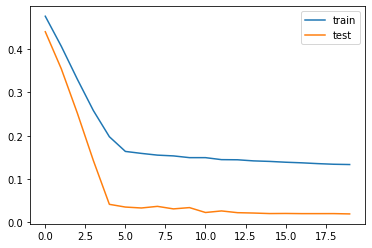

In [83]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [84]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.001


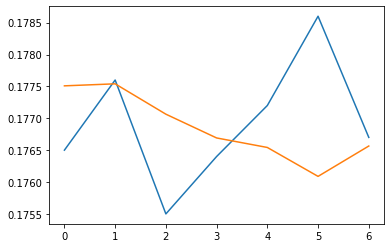

In [85]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.show()

In [90]:
# inv_y = np.insert(inv_y,0,500)

In [92]:
# plt.plot(inv_y)
# plt.plot(inv_yhat)
# plt.show()

Elephas Implementation

In [93]:
spark_df = sql.createDataFrame(df)
CleanDF = spark_df.withColumn("DateTime_casted",spark_df['DateTime'].cast(TimestampType()))
FinalDf = CleanDF.selectExpr("DateTime_casted as Date_Time", "Sentiment_score",'Price AS Price1')

NameError: ignored